### imports

In [36]:
import tensorflow as tf 
import numpy as np
import pandas as pd 
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition

from sklearn.feature_selection import SelectKBest
from tensorflow.keras.layers import LeakyReLU

### data preprocessing

In [37]:
df_mp = pd.read_csv('/home/april-ai/Desktop/UQ/MP_Data_Corrected/mp_data_100k_cleaned2.csv')

In [38]:
df_mp.head(20)

,Unnamed: 0.1,Unnamed: 0,nsites,composition,formula_pretty,volume,symmetry,material_id,structure,formation_energy_per_atom,...,mean ordering parameter shell 3,max packing efficiency,structural complexity per atom,structural complexity per cell,spacegroup_num,crystal_system,crystal_system_int,is_centrosymmetric,n_symmetry_ops,dimensionality
0,0,99994,10,Sr1 Cr1 H1 O2,SrCrHO2,116.010397,"{'crystal_system': 'Tetragonal', 'symbol': 'P4...",mp-1218324,"{'@module': 'pymatgen.core.structure', '@class...",-2.090215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,28876,12,Sc1 I1 O1,ScIO,279.252151,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-559760,"{'@module': 'pymatgen.core.structure', '@class...",-2.891759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,41418,40,Ga3 Bi5 Cl12,Ga3Bi5Cl12,1302.857133,"{'crystal_system': 'Trigonal', 'symbol': 'R3c'...",mp-569854,"{'@module': 'pymatgen.core.structure', '@class...",-1.229581,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,41414,10,Ag1 N1 O3,AgNO3,125.104504,"{'crystal_system': 'Trigonal', 'symbol': 'R3c'...",mp-552185,"{'@module': 'pymatgen.core.structure', '@class...",-0.680664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,28883,24,Tl1 Cr3 O8,TlCr3O8,361.671041,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-561221,"{'@module': 'pymatgen.core.structure', '@class...",-1.778230,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,68124,32,H3 N1 O4,H3NO4,288.735621,"{'crystal_system': 'Orthorhombic', 'symbol': '...",mp-626256,"{'@module': 'pymatgen.core.structure', '@class...",-1.054001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,28886,9,Cs4 Ir1 O4,Cs4IrO4,224.021475,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-561672,"{'@module': 'pymatgen.core.structure', '@class...",-1.445430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,28887,11,Mg2 As2 O7,Mg2As2O7,130.063963,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-5618,"{'@module': 'pymatgen.core.structure', '@class...",-2.276241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,28888,12,Cs1 Ag3 S2,CsAg3S2,293.392351,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-561902,"{'@module': 'pymatgen.core.structure', '@class...",-0.497268,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,28889,36,K1 Te2 O6,K(TeO3)2,521.848713,"{'crystal_system': 'Monoclinic', 'symbol': 'C2...",mp-561973,"{'@module': 'pymatgen.core.structure', '@class...",-1.614327,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
len(df_mp)

21185

In [40]:
for column in df_mp.columns: 
    print(column)

Unnamed: 0.1
Unnamed: 0
nsites
composition
formula_pretty
volume
symmetry
material_id
structure
formation_energy_per_atom
energy_above_hull
band_gap
H
He
Li
Be
B
C
N
O
F
Ne
Na
Mg
Al
Si
P
S
Cl
Ar
K
Ca
Sc
Ti
V
Cr
Mn
Fe
Co
Ni
Cu
Zn
Ga
Ge
As
Se
Br
Kr
Rb
Sr
Y
Zr
Nb
Mo
Tc
Ru
Rh
Pd
Ag
Cd
In
Sn
Sb
Te
I
Xe
Cs
Ba
La
Ce
Pr
Nd
Pm
Sm
Eu
Gd
Tb
Dy
Ho
Er
Tm
Yb
Lu
Hf
Ta
W
Re
Os
Ir
Pt
Au
Hg
Tl
Pb
Bi
Po
At
Rn
Fr
Ra
Ac
Th
Pa
U
Np
Pu
Am
Cm
Bk
Cf
Es
Fm
Md
No
Lr
Rf
Db
Sg
Bh
Hs
Mt
Ds
Rg
Cn
Nh
Fl
Mc
Lv
Ts
Og
transition metal fraction
0-norm
2-norm
3-norm
5-norm
7-norm
10-norm
band center
MagpieData minimum Number
MagpieData maximum Number
MagpieData range Number
MagpieData mean Number
MagpieData avg_dev Number
MagpieData mode Number
MagpieData minimum MendeleevNumber
MagpieData maximum MendeleevNumber
MagpieData range MendeleevNumber
MagpieData mean MendeleevNumber
MagpieData avg_dev MendeleevNumber
MagpieData mode MendeleevNumber
MagpieData minimum AtomicWeight
MagpieData maximum AtomicWeight
MagpieData range

In [41]:
unwanted_columns = ["builder_meta", "formula_anonymous", "property_name", "deprecated", 
                    "deprecated_reason", "last_updated", "last_updated_by", "origins", "warnings", "task_ids", "uncorrected_energy_per_atom", "is_stable", "is_metal", 
                    "equilibrum_reaction_energy_per_atom", "decomposes_to", "xas", "es_source_calc_id", "dos", "bandstructure", "dos_energy_up", "dos_energy_down",
                    "is_magnetic", "ordering", "total_magnetization", "total_magnetization_normalized_vol", "total_magnetization_normalized_formula_units", "num_magnetic_sites", 
                    "num_unique_magnetic_sites", "types_of_magnetic_species", "universal_anisotropy", "homogenous_poisson", "e_total", "e_ionic", "e_elctronic", "n", "e_ij_max", 
                    "weightded_sace_energy_EV_PER_ANG2", "weighted_surface_energy", "weighted_work_function","surface_anisotropy", "shape_factor", "has_reconstructed",
                     "possible_species", "has_props", "theoretical", "database_IDs", "fields_not_requested"]
# Remove unwanted columns
df_mp = df_mp.drop(columns=unwanted_columns, errors='ignore')

df_mp = df_mp.drop(columns=["deprecation_reasons","equilibrum_reaction_energy_per_atom", "deprecation_reasons", "equilibrum_reaction_energy_per_atom", "grain_boundaries", 
                            "cbm", "vbm", "efermi", "is_gap_direct", "homogenous_poisson", "e_electronic", "weighted_surface_energy_EV_PER_ANG2", "shear_modulus", "bulk_modulus"], errors='ignore')

df_mp.drop(columns=["shear_modulus", "bulk_modulus"], inplace=True, errors='ignore')

In [42]:
#If there are two same elements in the composition, drop one with higher energy above hull

def drop_duplicate_elements(df):
    # Group by 'composition' and keep the one with the lowest 'energy_above_hull'
    df = df.sort_values(by="energy_above_hull")
    df = df.drop_duplicates(subset=["composition"], keep='first')
    return df

df_mp = drop_duplicate_elements(df_mp)
df_mp.head()

,Unnamed: 0.1,Unnamed: 0,nsites,composition,formula_pretty,volume,symmetry,material_id,structure,formation_energy_per_atom,...,mean ordering parameter shell 3,max packing efficiency,structural complexity per atom,structural complexity per cell,spacegroup_num,crystal_system,crystal_system_int,is_centrosymmetric,n_symmetry_ops,dimensionality
0,0,99994,10,Sr1 Cr1 H1 O2,SrCrHO2,116.010397,"{'crystal_system': 'Tetragonal', 'symbol': 'P4...",mp-1218324,"{'@module': 'pymatgen.core.structure', '@class...",-2.090215,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5909,5909,48639,36,Nd2 W1 O6,Nd2WO6,512.785562,"{'crystal_system': 'Orthorhombic', 'symbol': '...",mp-18057,"{'@module': 'pymatgen.core.structure', '@class...",-3.237746,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5908,5908,48640,24,Cs1 Ag1 Se4,CsAgSe4,764.008692,"{'crystal_system': 'Orthorhombic', 'symbol': '...",mp-18105,"{'@module': 'pymatgen.core.structure', '@class...",-0.712835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5907,5907,48641,40,Ba1 Sb1 Te3,BaSbTe3,1480.081231,"{'crystal_system': 'Orthorhombic', 'symbol': '...",mp-18291,"{'@module': 'pymatgen.core.structure', '@class...",-1.041214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5906,5906,48642,24,Rb1 Cu1 Se4,RbCuSe4,667.679359,"{'crystal_system': 'Orthorhombic', 'symbol': '...",mp-18365,"{'@module': 'pymatgen.core.structure', '@class...",-0.722637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
def get_rid_of_singular_elements(df):
    # Filter out rows where 'composition' contains only one element

    for element in df["composition"]:
        if isinstance(element, str) and " " in element:
            # If the composition is a string with multiple elements, keep it
            continue
        else:
            # If the composition is a single element, drop the row
            df = df[df["composition"] != element]   
    return df

df_mp = get_rid_of_singular_elements(df_mp)
    

In [44]:
df_mp = df_mp[(df_mp['band_gap'] > 0.2)]
y = df_mp['band_gap']

print(len(y))

print(y)


21185
0        0.5556
5909     3.7285
5908     1.2669
5907     0.6207
5906     1.0105
          ...  
21180    0.3520
21181    0.3212
21182    0.2318
21183    0.2004
21184    1.1250
Name: band_gap, Length: 21185, dtype: float64


In [45]:
"""
# Define and clean inputs
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')

#
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

# Step 4: Feature scaling
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Step 5: Feature selection AFTER scaling
#X_selected = SelectKBest(score_func=f_regression, k=30).fit_transform(X_scaled, y)

# Step 6: Train-test split on selected features and aligned y
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)
"""

'\n# Define and clean inputs\ny = df_mp[\'band_gap\'].values\nexcluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites"]\nX = df_mp.drop(columns=excluded + ["band_gap"], errors=\'ignore\')\n\n#\noriginal_indices = df_mp.index.to_numpy()\nformulas = df_mp.loc[original_indices, "formula_pretty"].values\n\n# Step 4: Feature scaling\n#scaler = StandardScaler()\n#X_scaled = scaler.fit_transform(X)\n\n# Step 5: Feature selection AFTER scaling\n#X_selected = SelectKBest(score_func=f_regression, k=30).fit_transform(X_scaled, y)\n\n# Step 6: Train-test split on selected features and aligned y\nX_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(\n    X, y, original_indices, test_size=0.2, random_state=42\n)\n'

In [46]:
# Step 1: Extract target and drop metadata columns
y = df_mp['band_gap'].values
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)



# Keep track of indices and formulas (optional, for post-analysis)
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values


# --- Train / test split first --------------------------------
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

pca = PCA(n_components=10)


X_pca = pca.fit_transform(X)
#build pipeline to avoid leakage
pipe = Pipeline([
    ('scaler', StandardScaler()),
    #('pca',    PCA(n_components=10))
])

X_train_scaled = pipe.fit_transform(X_train)   # fit only on training set
X_test_scaled  = pipe.transform(X_test)        # transform test set




In [47]:
""" 
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'x{i}' for i in range(X_train.shape[1])]

pca = pipe.named_steps['pca']

# For each PC, get the top N contributing features by absolute weight
top_features_per_pc = {}
n_top = 10  

""" 
""" 
Each principal component is a linear combination of the original features, chosen so that:

The first principal component captures the largest possible variance (spread) in the data.
The second principal component captures the next largest variance, but is uncorrelated (orthogonal) to the first, and so on.

"""
""" 

#loop over each principal component 
for i, component in enumerate(pca.components_): #components_ -> Principal axes in feature space, representing the directions of maximum variance in the data.
    sorted_idx = np.argsort(np.abs(component))[::-1][:n_top] # ge tindices of top n features by absolute weight
    top_features = [(feature_names[j], component[j]) for j in sorted_idx] # get pairs of (feature_name, weights) 
    top_features_per_pc[f'PC{i+1}'] = top_features

#Note: , the "weight" (or loading) tells you how much a particular original feature contributes to 
#a principal component—not how "good" the component is.

# View results
for pc, features in top_features_per_pc.items():
    print(f'\nTop {n_top} features for {pc}:')
    for name, weight in features:
        print(f'  {name}: {weight:.4f}')
""" 

' \n\n#loop over each principal component \nfor i, component in enumerate(pca.components_): #components_ -> Principal axes in feature space, representing the directions of maximum variance in the data.\n    sorted_idx = np.argsort(np.abs(component))[::-1][:n_top] # ge tindices of top n features by absolute weight\n    top_features = [(feature_names[j], component[j]) for j in sorted_idx] # get pairs of (feature_name, weights) \n    top_features_per_pc[f\'PC{i+1}\'] = top_features\n\n#Note: , the "weight" (or loading) tells you how much a particular original feature contributes to \n#a principal component—not how "good" the component is.\n\n# View results\nfor pc, features in top_features_per_pc.items():\n    print(f\'\nTop {n_top} features for {pc}:\')\n    for name, weight in features:\n        print(f\'  {name}: {weight:.4f}\')\n'

In [48]:
def gaussian_nll(y_true, y_pred):
    """
    A mathematically complete Gaussian Negative Log-Likelihood loss.
    """
    # Ensure y_true is a float and flattened
    y_true = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)

    # Extract the mean and log-variance from the model's predictions
    mu = y_pred[:, 0]
    log_var = y_pred[:, 1]
    
    # The precision term (1 / variance)
    precision = tf.exp(-log_var)
    
    # The log determinant term and the squared error term
    loss = log_var + (y_true - mu)**2 * precision
    
    # Add the constant and scale by 0.5
    loss = 0.5 * (tf.math.log(2. * np.pi) + loss)
    
    return tf.reduce_mean(loss)

In [49]:
def model(input_dim = 1, seed = 42):
    """
    Defines Monte Carlo Dropout model for regression with uncertainity 

    Args: 
        input_dim (int): NUmber of input features
        seed (int): Random seed for reproducibility

    Returns: 
        compiled Keras model 
    """
    tf.random.set_seed(seed)

    model = Sequential([
        Dense(256, input_shape=(input_dim,)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(128),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        Dense(64),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(2)  # [mean, log(variance)]
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = gaussian_nll)

    return model


def train(x, y, model, x_val=None, y_val=None, epochs=100):
    history = model.fit(x, y,
                        validation_data=(x_val, y_val) if x_val is not None else None,
                        batch_size=32,
                        epochs=epochs,
                        verbose=1)
    return model, history


def predict(model, x, samples = 20): 
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        y_mean: The expected value of our prediction
        y_std: The standard deviation of our prediction
    '''

    mu_arr = []
    si_arr = []

    for t in range(samples):
        y_pred = model(x, training=True)
        mu = y_pred[:, 0]
        si = y_pred[:, 1]

        mu_arr.append(mu)
        si_arr.append(si)

    mu_arr = np.array(mu_arr)
    si_arr = np.array(si_arr)
    var_arr = np.exp(si_arr)

    y_mean = np.mean(mu_arr, axis=0)
    y_variance = np.mean(var_arr + mu_arr**2, axis=0) - y_mean**2
    y_std = np.sqrt(y_variance)
    
    return y_mean, y_std


In [50]:
# Define and train model
input_dim = X_train_scaled.shape[1]
mcd_model = model(input_dim=input_dim, seed=42)  # uses your improved model()

# Train the model
mcd_model, history = train(X_train_scaled, y_train, mcd_model, 
                           x_val=X_test_scaled, y_val=y_test, epochs=100)





/home/april-ai/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - loss: 2.4641 - val_loss: 1.4902
Epoch 2/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 1.6228 - val_loss: 1.3271
Epoch 3/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.4362 - val_loss: 1.2260
Epoch 4/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.3394 - val_loss: 1.1473
Epoch 5/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.2710 - val_loss: 1.0974
Epoch 6/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.2324 - val_loss: 1.0797
Epoch 7/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.2187 - val_loss: 1.1764
Epoch 8/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.1894 - val_loss: 1.0782
Epoch 9/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 1.1765 - val_loss: 1.0838
Epoch 10/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 1.1670 - val_loss: 1.0609
Epoch 11/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1.1641 - val_loss: 1.0195
Epoch 12/100
530/530 ━━━━━━

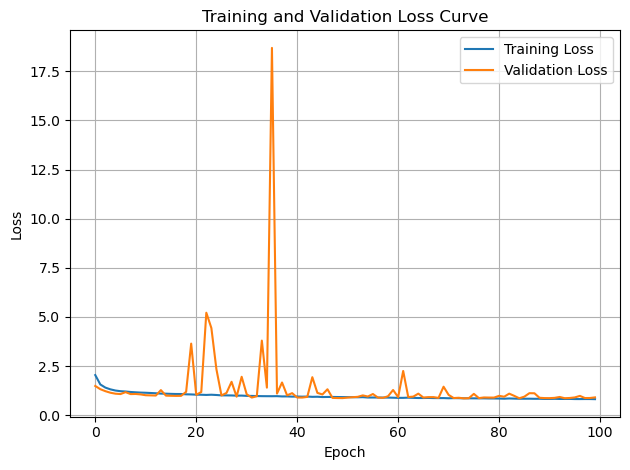

In [51]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# Make predictions with uncertainty (in scaled space)
y_pred_mean, y_pred_std = predict(mcd_model, X_test_scaled, samples=50)

# Inverse-transform predictions and std to original scale
#y_pred_mean_orig = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
#y_pred_std_orig = y_pred_std * y_scaler.scale_[0]  # std scales by the scaler's scale

# Calculate R² in original space
r2 = r2_score(y_test, y_pred_mean)
print("R² score:", r2)

mse = mean_squared_error(y_test, y_pred_mean)
print("MSE:", mse)

R² score: 0.7833385999031665
MSE: 0.4585529926063461


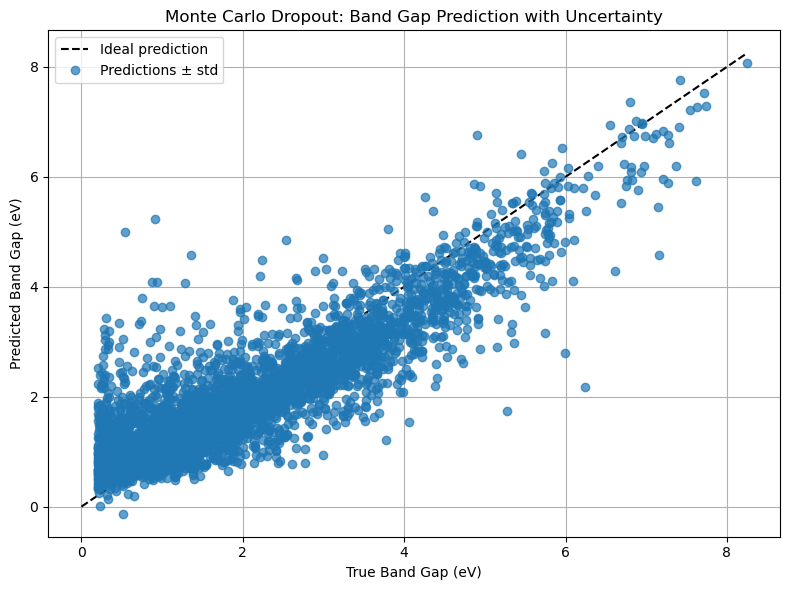

In [53]:
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred_mean, fmt='o', alpha=0.7, label='Predictions ± std')
plt.plot([0, max(y_test)], [0, max(y_test)], 'k--', label='Ideal prediction')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Monte Carlo Dropout: Band Gap Prediction with Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

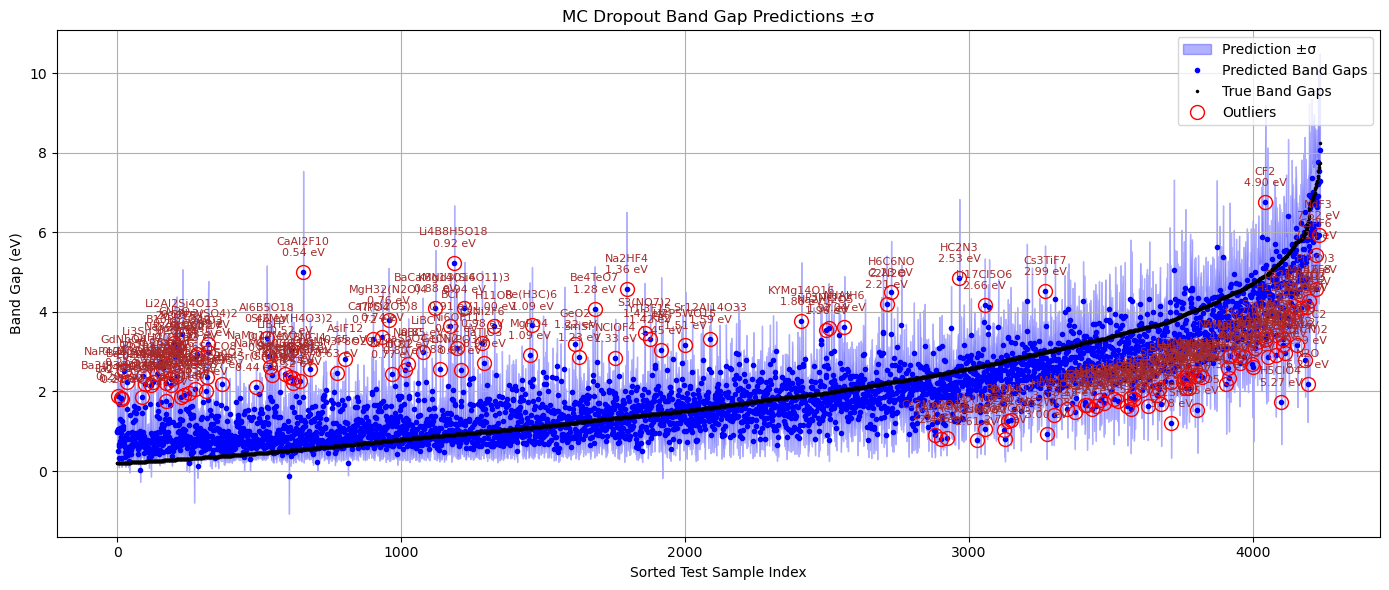

In [54]:

# Inverse-transform predictions and std to original scale
#y_pred_mean_orig = y_scaler.inverse_transform(y_pred_mean.reshape(-1, 1)).ravel()
#y_pred_std_orig = y_pred_std * y_scaler.scale_[0]

# Convert predictions and uncertainties to arrays
y_true = np.array(y_test)
y_predicted = np.array(y_pred_mean)
y_std_dev = np.array(y_pred_std)

# Sort by true band gap values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_predicted[sorted_idx]
y_std_sorted = y_std_dev[sorted_idx]

# Confidence interval (±σ)
lower = y_pred_sorted - y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Optional: retrieve formulas for annotation
formulas = df_mp.loc[idx_test, "formula_pretty"].values
formulas_sorted = formulas[sorted_idx]

# Calculate prediction error and identify outliers
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.5  # adjust threshold as needed
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))

# Confidence interval band
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')

# Predicted mean
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')

# True values
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')

# Outliers
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers with formula and true band gap
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

# Final formatting
plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


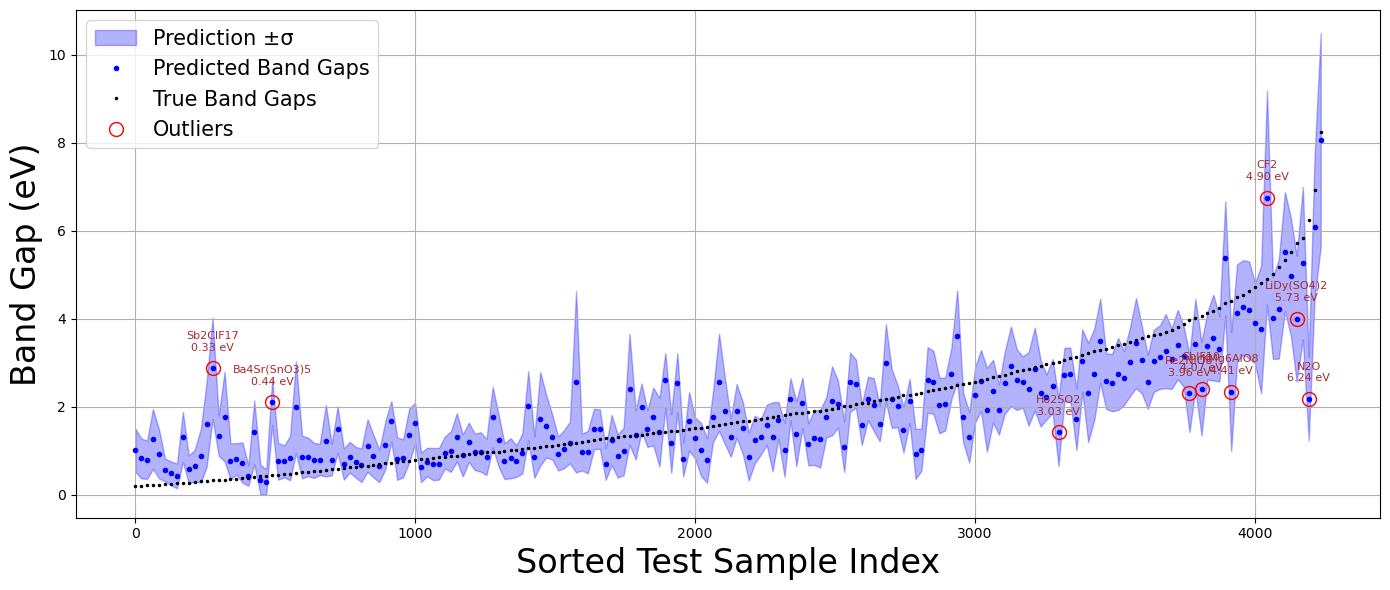

In [59]:

# Choose 200 evenly spaced indices
n_points = 200
indices = np.linspace(0, len(y_true_sorted) - 1, n_points, dtype=int)

# Subset arrays
y_true_sub = y_true_sorted[indices]
y_pred_sub = y_pred_sorted[indices]
y_std_sub = y_std_sorted[indices]
lower_sub = lower[indices]
upper_sub = upper[indices]
formulas_sub = formulas_sorted[indices]
errors_sub = errors[indices]
outlier_mask_sub = outlier_mask[indices]
outlier_indices_sub = np.where(outlier_mask_sub)[0]

plt.figure(figsize=(14, 6))
plt.fill_between(indices, lower_sub, upper_sub, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(indices, y_pred_sub, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(indices, y_true_sub, 'k.', markersize=3, label='True Band Gaps')
plt.plot(indices[outlier_indices_sub], y_pred_sub[outlier_mask_sub], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers (optional)
for i in outlier_indices_sub:
    plt.text(indices[i], y_pred_sub[i] + 0.4, f"{formulas_sub[i]}\n{y_true_sub[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Sorted Test Sample Index", fontsize = 24 )
plt.ylabel("Band Gap (eV)", fontsize=24)
#plt.title("MC Dropout Band Gap Predictions ±σ (200 points)")
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

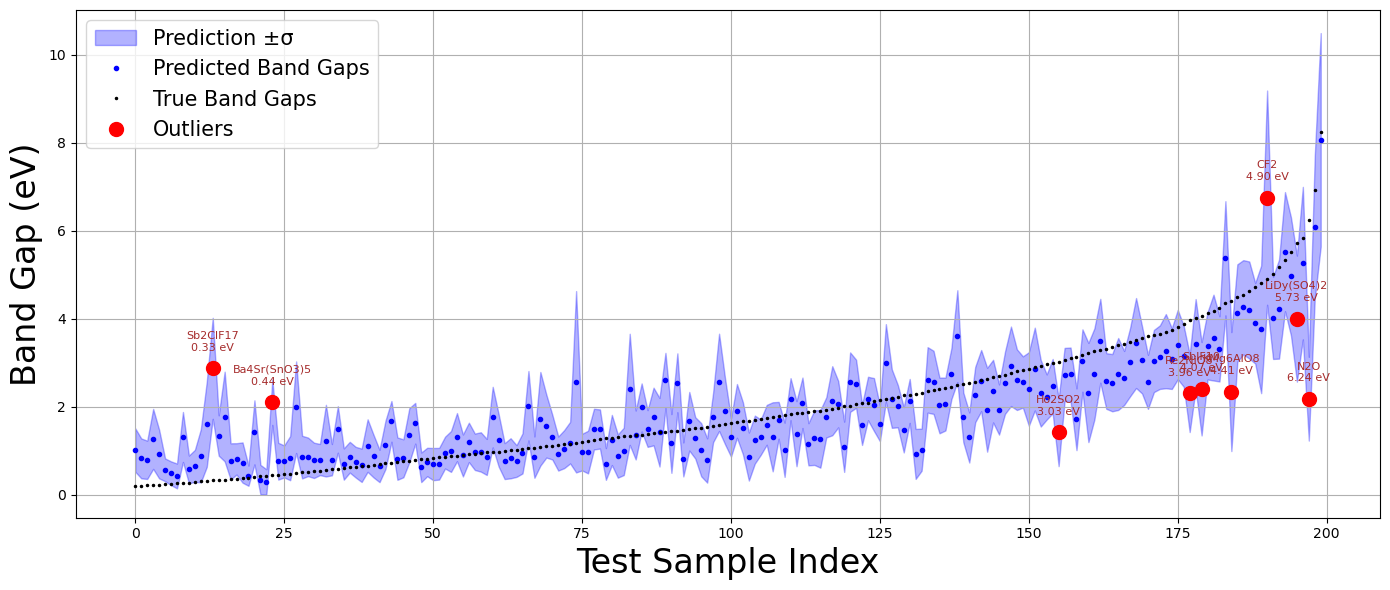

In [61]:
# Choose 200 evenly spaced indices
n_points = 200
indices = np.linspace(0, len(y_true_sorted) - 1, n_points, dtype=int)

# Subset arrays
y_true_sub = y_true_sorted[indices]
y_pred_sub = y_pred_sorted[indices]
y_std_sub = y_std_sorted[indices]
lower_sub = lower[indices]
upper_sub = upper[indices]
formulas_sub = formulas_sorted[indices]
errors_sub = errors[indices]
outlier_mask_sub = outlier_mask[indices]
outlier_indices_sub = np.where(outlier_mask_sub)[0]

# New x-axis for plotting: just 0 to 199
x_plot = np.arange(n_points)

plt.figure(figsize=(14, 6))
plt.fill_between(x_plot, lower_sub, upper_sub, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(x_plot, y_pred_sub, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(x_plot, y_true_sub, 'k.', markersize=3, label='True Band Gaps')
plt.plot(x_plot[outlier_indices_sub], y_pred_sub[outlier_mask_sub], 'ro', markerfacecolor='red', markersize=10, label='Outliers')

# Annotate outliers (optional)
for i in outlier_indices_sub:
    plt.text(x_plot[i], y_pred_sub[i] + 0.4, f"{formulas_sub[i]}\n{y_true_sub[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Test Sample Index", fontsize=24)
plt.ylabel("Band Gap (eV)", fontsize=24)
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()


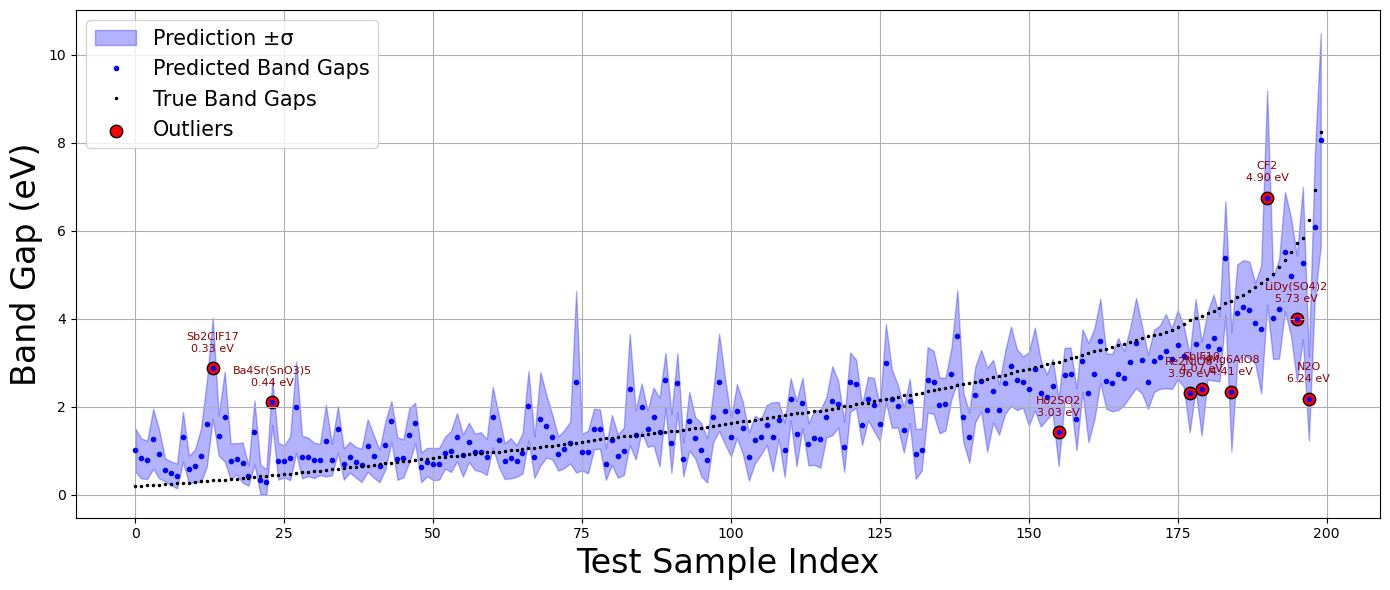

R² score: 0.7833385999031665
MSE: 0.4585529926063461


In [65]:
# Choose 200 evenly spaced indices
n_points = 200
indices = np.linspace(0, len(y_true_sorted) - 1, n_points, dtype=int)

# Subset arrays
y_true_sub = y_true_sorted[indices]
y_pred_sub = y_pred_sorted[indices]
y_std_sub = y_std_sorted[indices]
lower_sub = lower[indices]
upper_sub = upper[indices]
formulas_sub = formulas_sorted[indices]
errors_sub = errors[indices]
outlier_mask_sub = outlier_mask[indices]
outlier_indices_sub = np.where(outlier_mask_sub)[0]

# New x-axis: from 0 to 199
x_plot = np.arange(n_points)

plt.figure(figsize=(14, 6))
plt.fill_between(x_plot, lower_sub, upper_sub, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(x_plot, y_pred_sub, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(x_plot, y_true_sub, 'k.', markersize=3, label='True Band Gaps')

# Outlier scatter + annotation
if len(outlier_indices_sub) > 0:
    plt.scatter(x_plot[outlier_indices_sub], y_pred_sub[outlier_indices_sub],
                edgecolor='black', facecolor='red', s=80, label='Outliers')
    
    for i, idx in enumerate(outlier_indices_sub):
        formula = formulas_sub[idx] if idx < len(formulas_sub) else ""
        plt.annotate(f"{formula}\n{y_true_sub[idx]:.2f} eV",
                     (x_plot[idx], y_pred_sub[idx]),
                     textcoords="offset points", xytext=(0, 12),
                     ha='center', fontsize=8, color='darkred')

plt.xlabel("Test Sample Index", fontsize=24)
plt.ylabel("Band Gap (eV)", fontsize=24)
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

r2 = r2_score(y_test, y_pred_mean)
print("R² score:", r2)  
mse = mean_squared_error(y_test, y_pred_mean)
print("MSE:", mse)


In [56]:
def plot_uncertainty(
    y_test,
    y_pred_mean,
    y_pred_std,
    outlier_mask=None,
    formulas=None,
    title="Uncertainty Prediction (±σ)",
    file_name=None,
    max_points=200  # << New argument
):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import r2_score, mean_squared_error

    # Limit to first N points
    y_test = y_test[:max_points]
    y_pred_mean = y_pred_mean[:max_points]
    y_pred_std = y_pred_std[:max_points]
    if outlier_mask is not None:
        outlier_mask = outlier_mask[:max_points]
    if formulas is not None:
        formulas = formulas[:max_points]

    # Compute confidence bounds
    lower = y_pred_mean - y_pred_std
    upper = y_pred_mean + y_pred_std

    # Sort by true values
    x = np.arange(len(y_test))
    sorted_idx = np.argsort(y_test)
    y_test_sorted = y_test[sorted_idx]
    y_pred_sorted = y_pred_mean[sorted_idx]
    y_std_sorted = y_pred_std[sorted_idx]
    lower_sorted = lower[sorted_idx]
    upper_sorted = upper[sorted_idx]

    if outlier_mask is not None:
        outlier_indices = np.where(outlier_mask[sorted_idx])[0]
    else:
        outlier_indices = []

    # Plot
    plt.figure(figsize=(16, 6))
    plt.fill_between(x, lower_sorted, upper_sorted, color='blue', alpha=0.3, label='Prediction ±σ')
    plt.plot(x, y_pred_sorted, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_test_sorted, 'k.', markersize=3, label='True Band Gaps')

    if len(outlier_indices) > 0:
        plt.scatter(x[outlier_indices], y_pred_sorted[outlier_indices],
                    edgecolor='black', facecolor='red', s=80, label='Outliers')
        if formulas is not None:
            for i, idx in enumerate(outlier_indices):
                formula = formulas[i] if i < len(formulas) else ""
                plt.annotate(f"{formula}\n{y_test_sorted[idx]:.2f} eV",
                             (x[idx], y_pred_sorted[idx]),
                             textcoords="offset points", xytext=(0, 12),
                             ha='center', fontsize=8, color='darkred')

    plt.xlabel("Test Sample Index", fontsize=20)
    plt.ylabel("Band Gap (eV)", fontsize=20)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()

    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()

    # Print metrics
    r2 = r2_score(y_test, y_pred_mean)
    mse = mean_squared_error(y_test, y_pred_mean)
    print(f"R² score: {r2:.3f}")
    print(f"MSE: {mse:.3f}")
    


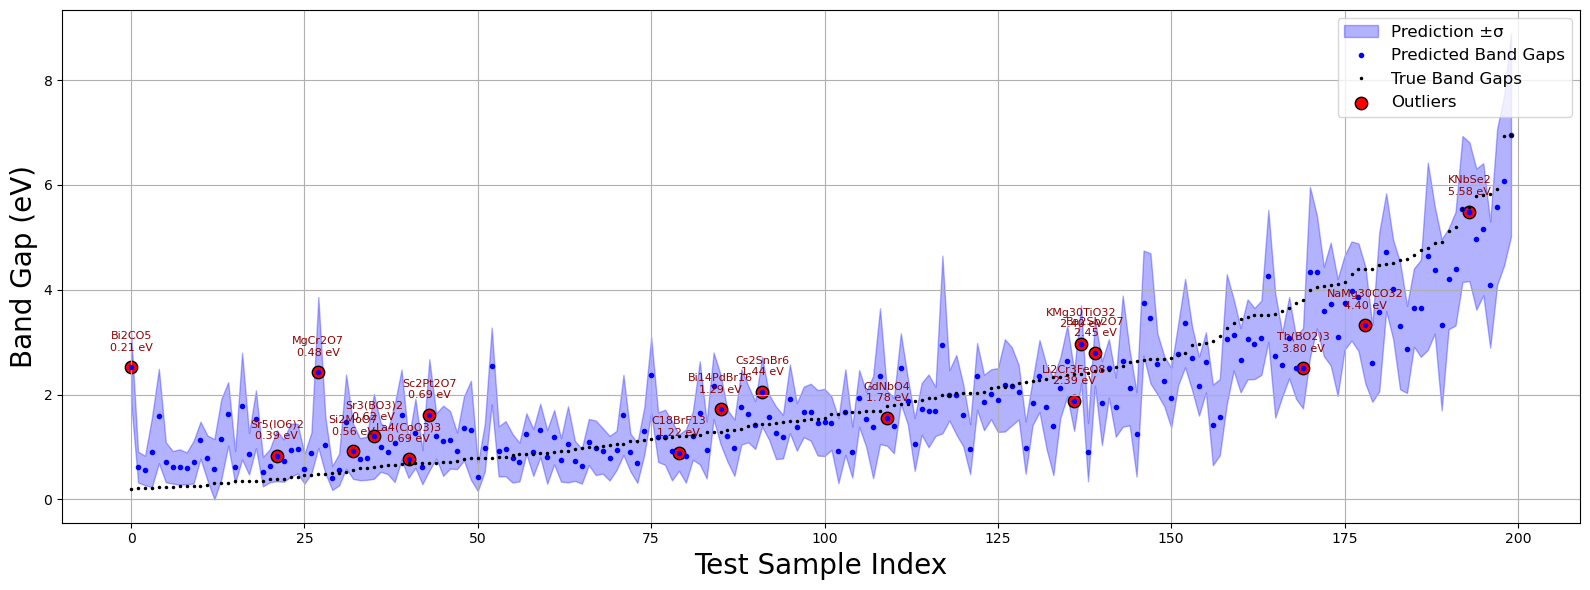

R² score: 0.811
MSE: 0.448


In [57]:
plot_uncertainty(
    y_test=y_test,
    y_pred_mean=y_pred_mean,
    y_pred_std=y_pred_std,
    outlier_mask=outlier_mask,
    formulas=formulas[outlier_indices],  # optional
    #title="MC Dropout Band Gap Predictions (±σ)",
    # file_name="bandgap_uncertainty_plot.png"
)



### Log transformed data

In [58]:
"""def model_log(input_dim = 1, seed = 42):
    """
  """
    Defines Monte Carlo Dropout model for regression with uncertainity 

    Args: 
        input_dim (int): NUmber of input features
        seed (int): Random seed for reproducibility

    Returns: 
        compiled Keras model 
    """
  """
    tf.random.set_seed(seed)

    model = Sequential([
        Dense(256, input_shape=(input_dim, )),  
        Activation('relu'), 
        Dropout(0.3),
        Dense(128), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(128), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(64), 
        Activation('relu'), 
        Dropout(0.3), 
        Dense(2)



    ])
     
    

    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss = gaussian_nll)

    return model


"""




IndentationError: unexpected indent (2832769854.py, line 3)

In [ ]:
"""# Step 1: Extract features and log-transform target
y = np.log1p(df_mp['band_gap'].values)  # log(1 + band_gap)
excluded = ["material_id", "composition", "formula_pretty", "symmetry", "structure", "sites", 'HOMO_character', 'HOMO_element', 'LUMO_character', 'LUMO_element']
X = df_mp.drop(columns=excluded + ["band_gap"], errors='ignore')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Step 2: Train/test split
original_indices = df_mp.index.to_numpy()
formulas = df_mp.loc[original_indices, "formula_pretty"].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, original_indices, test_size=0.2, random_state=42
)

# Step 3: Scale and select features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

In [ ]:
#print("Explained variance:", pca.explained_variance_ratio_)
#print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))

In [ ]:
"""input_dim = X_train_scaled.shape[1]
mcd_model = model_log(input_dim=input_dim, seed=42)
mcd_model, history = train(
    X_train_scaled, y_train,
    model=mcd_model,
    x_val=X_test_scaled,
    y_val = y_test,
    epochs=100
)
""" 


/home/april-ai/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 1.2177 - val_loss: 0.8494
Epoch 2/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.8173 - val_loss: 0.8165
Epoch 3/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.9452 - val_loss: 0.7286
Epoch 4/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.6430 - val_loss: 0.5811
Epoch 5/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.8138 - val_loss: 0.5514
Epoch 6/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 2.1151 - val_loss: 0.5175
Epoch 7/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.5996 - val_loss: 0.4916
Epoch 8/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.7991 - val_loss: 0.6061
Epoch 9/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.6132 - val_loss: 0.6907
Epoch 10/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.5590 - val_loss: 0.4204
Epoch 11/100
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.5010 - val_loss: 0.3802
Epoch 12/100
530/530 ━━━━━━━

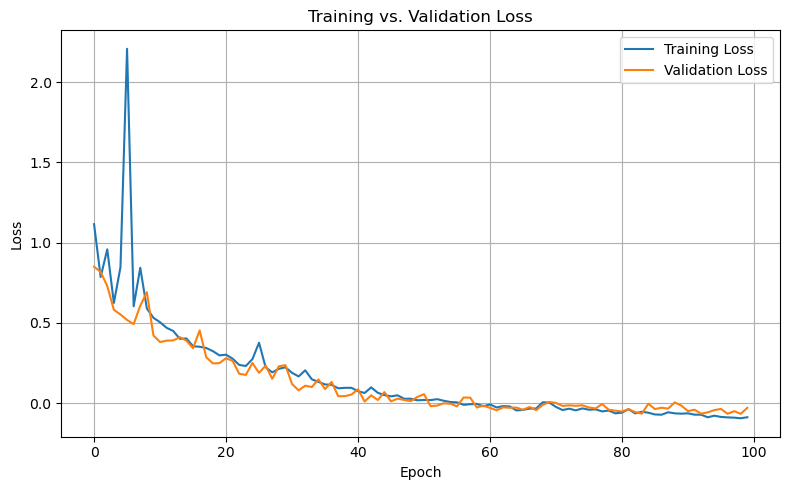

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
"""
# Predict (log space)
y_pred_log, y_std_log = predict(mcd_model, X_test_scaled, samples=50)

# Invert log1p transformation
y_pred = np.expm1(y_pred_log)
y_std = np.expm1(y_pred_log + y_std_log) - y_pred  # Approximate std in original space
y_true = np.expm1(y_test)

# Calculate R² in original space
r2 = r2_score(y_true, y_pred)
print("R² score:", r2)
""""""

R² score: 0.7582924782208968


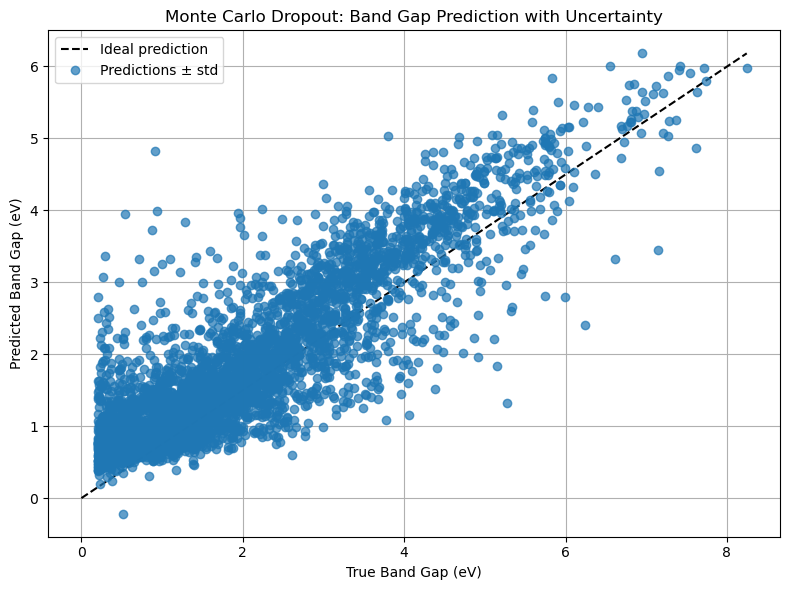

In [ ]:
plt.figure(figsize=(8, 6))
plt.errorbar(y_true, y_pred, fmt='o', alpha=0.7, label='Predictions ± std')
plt.plot([0, max(y_true)], [0, max(y_pred)], 'k--', label='Ideal prediction')
plt.xlabel("True Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("Monte Carlo Dropout: Band Gap Prediction with Uncertainty")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

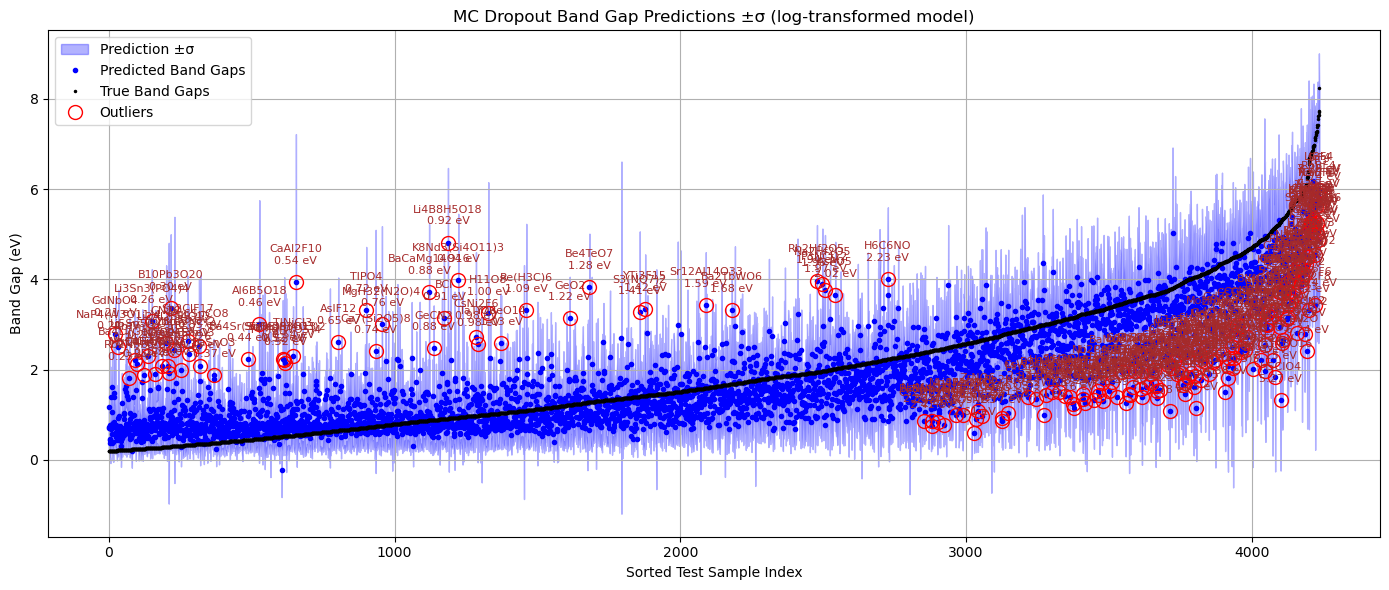

In [ ]:
# Sort by true values
sorted_idx = np.argsort(y_true)
y_true_sorted = y_true[sorted_idx]
y_pred_sorted = y_pred[sorted_idx]
y_std_sorted = y_std[sorted_idx]

# Confidence band
lower = y_pred_sorted - y_std_sorted
upper = y_pred_sorted + y_std_sorted

# Formulas for annotation
formulas_sorted = df_mp.loc[idx_test, "formula_pretty"].values[sorted_idx]

# Identify outliers
errors = np.abs(y_true_sorted - y_pred_sorted)
outlier_mask = errors > 1.5
outlier_indices = np.where(outlier_mask)[0]

# Plot
plt.figure(figsize=(14, 6))
plt.fill_between(range(len(y_true_sorted)), lower, upper, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(y_pred_sorted, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(y_true_sorted, 'k.', markersize=3, label='True Band Gaps')
plt.plot(outlier_indices, y_pred_sorted[outlier_mask], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers
for i in outlier_indices:
    plt.text(i, y_pred_sorted[i] + 0.4, f"{formulas_sorted[i]}\n{y_true_sorted[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ (log-transformed model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


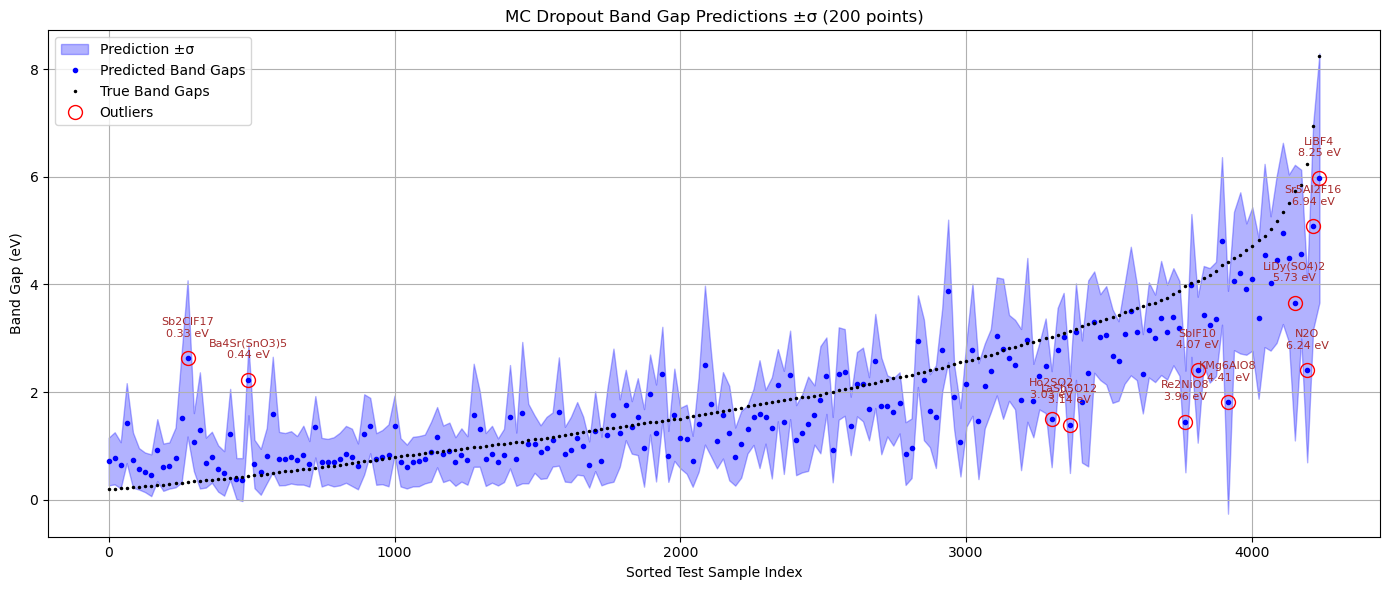

In [ ]:

# Choose 200 evenly spaced indices
n_points = 200
indices = np.linspace(0, len(y_true_sorted) - 1, n_points, dtype=int)

# Subset arrays
y_true_sub = y_true_sorted[indices]
y_pred_sub = y_pred_sorted[indices]
y_std_sub = y_std_sorted[indices]
lower_sub = lower[indices]
upper_sub = upper[indices]
formulas_sub = formulas_sorted[indices]
errors_sub = errors[indices]
outlier_mask_sub = outlier_mask[indices]
outlier_indices_sub = np.where(outlier_mask_sub)[0]

plt.figure(figsize=(14, 6))
plt.fill_between(indices, lower_sub, upper_sub, alpha=0.3, label='Prediction ±σ', color='blue')
plt.plot(indices, y_pred_sub, 'o', markersize=3, label='Predicted Band Gaps', color='blue')
plt.plot(indices, y_true_sub, 'k.', markersize=3, label='True Band Gaps')
plt.plot(indices[outlier_indices_sub], y_pred_sub[outlier_mask_sub], 'ro', markerfacecolor='none', markersize=10, label='Outliers')

# Annotate outliers (optional)
for i in outlier_indices_sub:
    plt.text(indices[i], y_pred_sub[i] + 0.4, f"{formulas_sub[i]}\n{y_true_sub[i]:.2f} eV", 
             fontsize=8, color='brown', ha='center')

plt.xlabel("Sorted Test Sample Index")
plt.ylabel("Band Gap (eV)")
plt.title("MC Dropout Band Gap Predictions ±σ (200 points)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def plot_uncertainty(
    x, y_true, y_pred, y_std, outlier_mask, formulas=None,
    title="Uncertainty Prediction (±σ)", file_name=None
):
    # Compute CI bounds
    lower = y_pred - y_std
    upper = y_pred + y_std

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    # Outlier handling
    outlier_indices = np.where(outlier_mask)[0]
    outlier_preds = y_pred[outlier_indices]

    # Begin plot
    plt.figure(figsize=(14, 6))
    plt.fill_between(x, lower, upper, color='blue', alpha=0.3, label='Prediction ±σ')
    plt.plot(x, y_pred, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_true, 'k.', markersize=3, label='True Band Gaps')
    plt.scatter(x[outlier_indices], outlier_preds, edgecolor='black', facecolor='red', s=80, label='Outliers')

    # Annotate outliers (optional)
    if formulas is not None:
        for i, idx in enumerate(outlier_indices):
            plt.annotate(
                f"{formulas[i]}\n{y_true[idx]:.2f} eV",
                (x[idx], y_pred[idx]),
                textcoords="offset points",
                xytext=(0, 12),
                ha='center',
                fontsize=8,
                color='darkred'
            )
    
    plt.xlabel("Test Sample Index", fontsize=24)
    plt.ylabel("Band Gap (eV)", fontsize=24)
    #plt.title(f"{title}\nR²: {r2:.3f} | MSE: {mse:.3f}", fontsize=20)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.tight_layout()



    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()

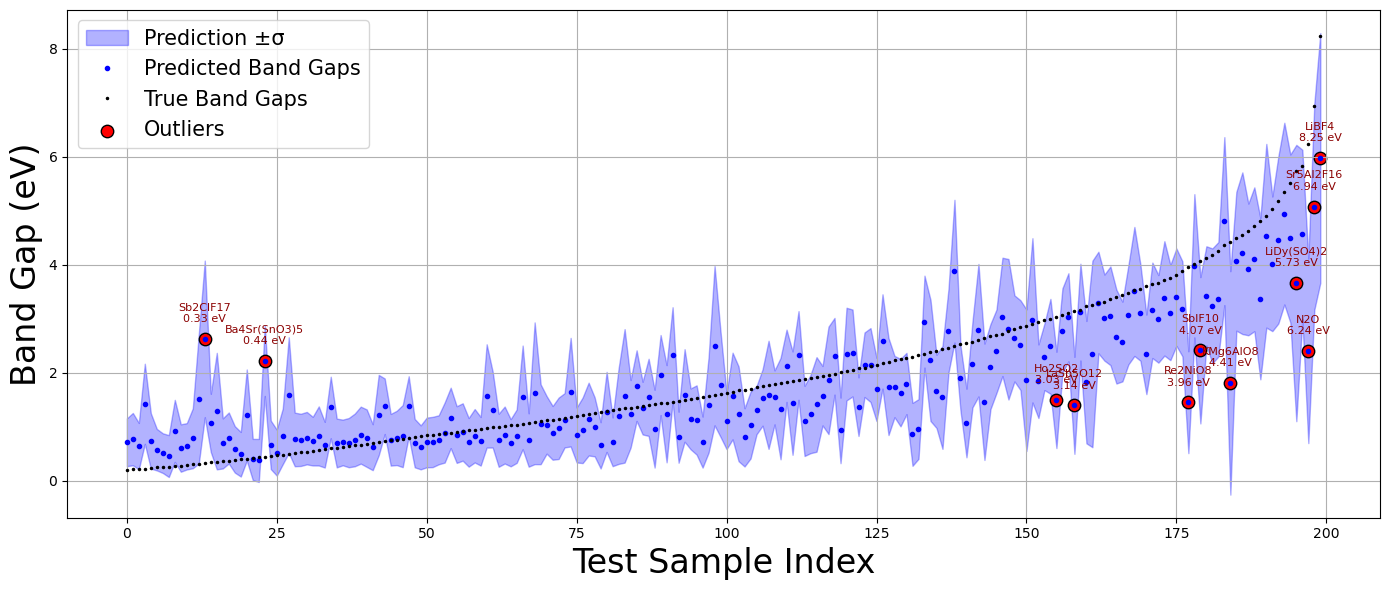

In [ ]:
x = np.arange(200)
plot_uncertainty(
    x, y_true_sub, y_pred_sub, y_std_sub, outlier_mask_sub, 
    formulas=formulas_sub[outlier_indices_sub],
    title="MC Dropout Band Gap Predictions (±σ)",
    file_name="MC_Dropout_BandGap.png"
)


### 95% CI

In [ ]:

def plot_95ci(
    x, y_true, y_pred, y_std, outlier_mask, formulas=None,
    title="Prediction with 95% Confidence Interval", file_name=None
):
    # 95% CI bounds assuming normal distribution: ±1.96 * std
    ci_multiplier = 1.96
    lower = y_pred - ci_multiplier * y_std
    upper = y_pred + ci_multiplier * y_std

    # Compute metrics
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    # Outlier handling
    outlier_indices = np.where(outlier_mask)[0]
    outlier_preds = y_pred[outlier_indices]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.fill_between(x, lower, upper, color='blue', alpha=0.3, label='95% Confidence Interval')
    plt.plot(x, y_pred, 'o', markersize=3, color='blue', label='Predicted Band Gaps')
    plt.plot(x, y_true, 'k.', markersize=3, label='True Band Gaps')
    plt.scatter(x[outlier_indices], outlier_preds, edgecolor='black', facecolor='red', s=80, label='Outliers')

    # Annotate outliers
    if formulas is not None:
        for i, idx in enumerate(outlier_indices):
            plt.annotate(
                f"{formulas[i]}\n{y_true[idx]:.2f} eV",
                (x[idx], y_pred[idx]),
                textcoords="offset points",
                xytext=(0, 12),
                ha='center',
                fontsize=8,
                color='darkred'
            )

    plt.xlabel("Test Sample Index")
    plt.ylabel("Band Gap (eV)")
    plt.title(f"{title}\nR²: {r2:.3f} | MSE: {mse:.3f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if file_name:
        plt.savefig(file_name, dpi=300)
    else:
        plt.show()


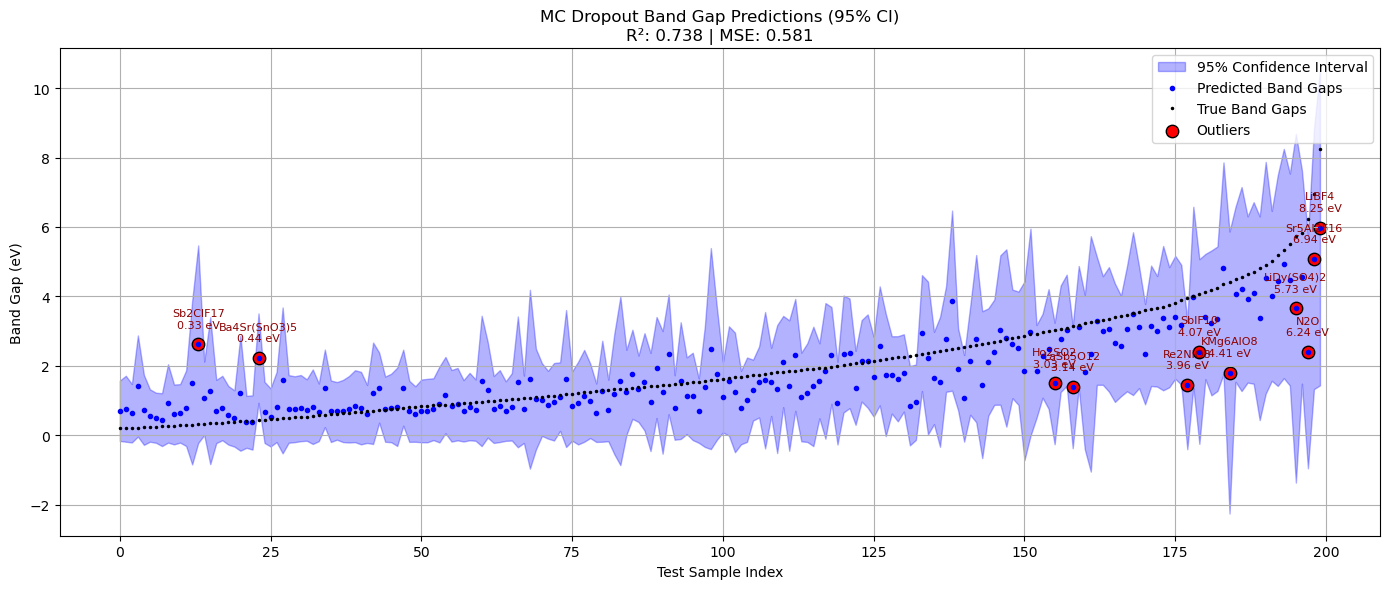

In [ ]:
x = np.arange(200)
plot_95ci(
    x, y_true_sub, y_pred_sub, y_std_sub, outlier_mask_sub, 
    formulas=formulas_sub[outlier_indices_sub],
    title="MC Dropout Band Gap Predictions (95% CI)",
    #file_name="MC_Dropout_BandGap.png"
)
